# Functions

In [3]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
# import logging
# logging.getLogger().setLevel(logging.CRITICAL)

In [4]:
from scipy.io import loadmat
exp_folder = 'D:\\GoogleDrive\\retina\\Troy\'s data\\20210908\\SplitData\\'
# for Fc in [1, 4]:
dt = 0.01
cmind = 0
Mean = 10
STD = 2
Mag_list = [0.2,0.6,1,1.3]
channelnumbers = [30, 26, 32, 15]

c1 = 0
Spike_list = [0]*len(Mag_list)
for Mag in Mag_list:
    
    if Mag == 1:
        filename = 'diode_OU_tau=500ms_cutoff=1_mean='+str(Mean)+'_amp='+str(STD)+'_11-Aug-2021_0'

    else:
        filename = 'diode_OU_tau=500ms_cutoff=1_coeff='+str(Mag)+'_11-Aug-2021_0'
    annots = loadmat(exp_folder+filename)
    TimeStamps =np.round(np.squeeze(annots['TimeStamps']))
    Spike_list[c1] = [0]*len(channelnumbers)
    c2=0
    for channelnumber in channelnumbers:
        Spike = np.squeeze( annots['Spikes'][0][channelnumber-1]-TimeStamps[0] )
        Spike = np.delete(Spike, np.where(Spike<=0))
        Spike_list[c1][c2] = Spike.copy()
        c2+=1
        # print(str(Mag)+'; '+str(len(Spike)/300))
    c1+=1

Spike2DList = np.array(Spike_list)

C:\Users\hydro_leo\anaconda3\lib\site-packages\ipykernel_launcher.py:32: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


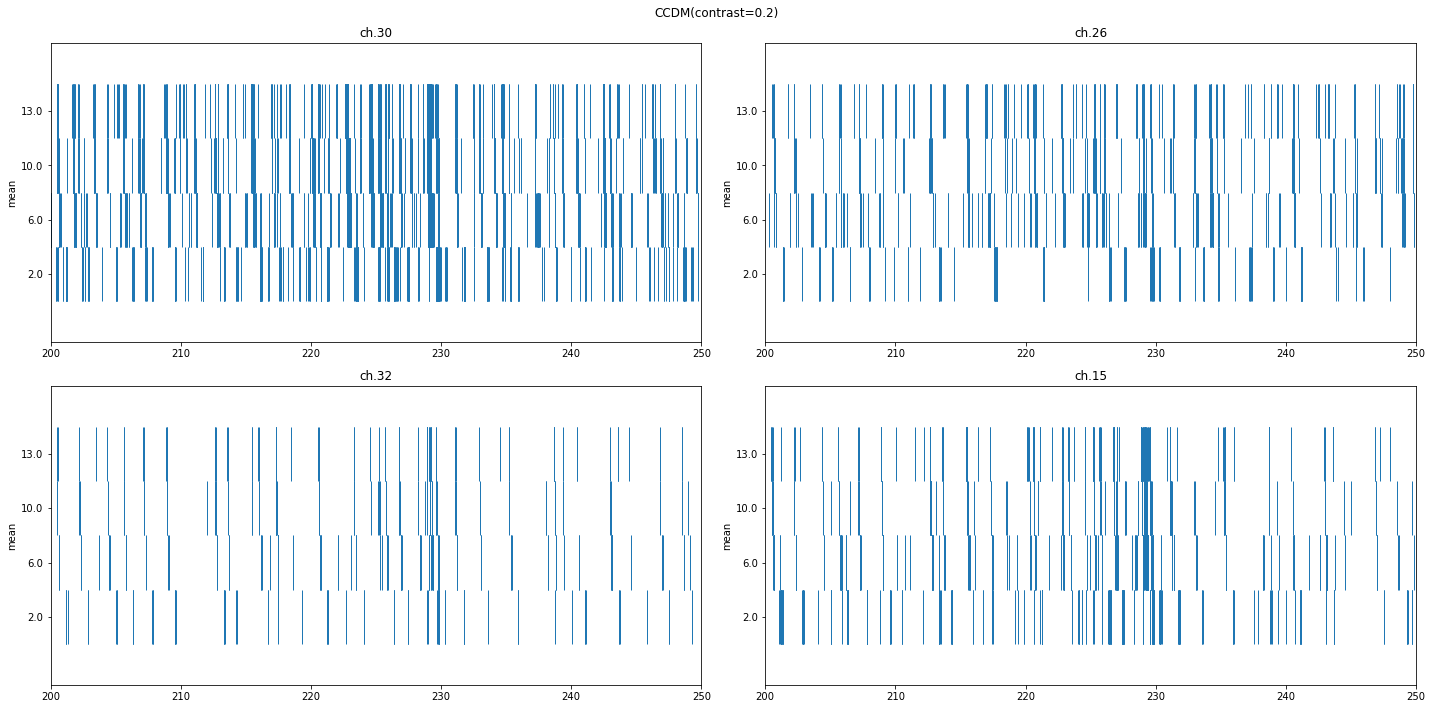

In [5]:
fig, ax = plt.subplots(2,2)
c2=0
fig.suptitle('CCDM(contrast=0.2)')
for channelnumber in channelnumbers:
    ax.flatten()[c2].eventplot(Spike2DList[:,c2], linewidths=1)
    ax.flatten()[c2].set_yticks(np.arange(len(Mag_list)))
    ax.flatten()[c2].set_yticklabels(np.array(Mag_list)*Mean)
    ax.flatten()[c2].set_title('ch.'+str(channelnumber))
    ax.flatten()[c2].set_ylabel('mean')
    # plt.xlim(0,50)
    ax.flatten()[c2].set_xlim(200,250)
    c2+=1
fig.set_size_inches(20, 10)
fig.tight_layout()